In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#Problem Statement: This problem includes complaints of different customers, regarding various products offered by the 
# organization. Our job included categorinzing the problems under the indicated product as well as predicting 
# the product that might be more prone from customers and can prove to be troublesome for the same.

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/npci-consumer-finance-complaints/sample_submission.csv
/kaggle/input/npci-consumer-finance-complaints/train.csv
/kaggle/input/npci-consumer-finance-complaints/test.csv


In [2]:
data=pd.read_csv("/kaggle/input/npci-consumer-finance-complaints/train.csv")
data.shape

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2684453, 17)

In [3]:
data.head(2).T

,0,1
Date received,2016-10-03,2020-02-27
Product,Credit reporting,Personal consumer reports
Issue,Incorrect information on credit report,Incorrect information on your report
Sub-issue,Account terms,Information belongs to someone else
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,"EQUIFAX, INC.","EQUIFAX, INC."
State,AZ,GA
ZIP code,85249.0,30043.0
Tags,NaN,NaN


In [4]:
# Create a new dataframe with two columns
df1 = data[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape

(961966, 2)

In [5]:
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(data)*100),1)


35.8

In [6]:
pd.DataFrame(data.Product.unique()).values

array([['Credit reporting'],
       ['Personal consumer reports'],
       ['Mortgage'],
       ['Debt collection'],
       ['Checking or savings account'],
       ['Money service'],
       ['Prepaid card'],
       ['Bank account or service'],
       ['Credit card'],
       ['Vehicle loan or lease'],
       ['Money transfers'],
       ['Payday loan'],
       ['Student loan'],
       ['Personal loan'],
       ['Consumer Loan'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

In [7]:
df2 = df1.sample(10000, random_state=1).copy()

In [8]:
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [9]:
pd.DataFrame(df2.Product.unique())

,0
0,Debt collection
1,Personal consumer reports
2,Consumer Loan
3,"Credit reporting, repair, or other"
4,Checking or savings account
5,Mortgage
6,Student loan
7,Bank account or service
8,Vehicle loan or lease
9,Credit card or prepaid card


In [10]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
665835,Debt collection,"Alltran Financial, based in XXXX/XXXX, TX cont...",0
729609,Personal consumer reports,"Hi, I there are fraud items on my credit repor...",1
2505600,Debt collection,DEBT COLLECTION COMPANY IS REPORTING INACCURAT...,0
648724,Consumer Loan,I was shocked when I reviewed my credit report...,2
2558370,Debt collection,After receiving a bill from them I contacted t...,0


In [11]:
import matplotlib.pyplot as plt

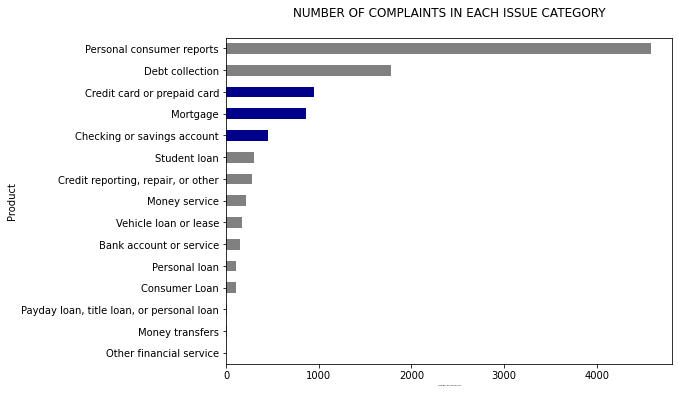

In [12]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH ISSUE CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 2);

In [13]:
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [14]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 27089 features (TF-IDF score of unigrams and bigrams)


In [15]:
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Bank account or service:
  * Most Correlated Unigrams are: overdraft, promotion, citigold
  * Most Correlated Bigrams are: checking account, citigold account, promotional code


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Checking or savings account:
  * Most Correlated Unigrams are: atm, bank, checking
  * Most Correlated Bigrams are: debit card, savings account, checking account


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Consumer Loan:
  * Most Correlated Unigrams are: financed, truck, toyota
  * Most Correlated Bigrams are: dealer services, installment loan, toyota financial


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Credit card or prepaid card:
  * Most Correlated Unigrams are: express, citi, card
  * Most Correlated Bigrams are: balance transfer, american express, credit card


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: transunion, reinserted, equifax
  * Most Correlated Bigrams are: year statute, victim inquiry, tax lien


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: collection agency, debt collection, collect debt


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Money service:
  * Most Correlated Unigrams are: zelle, paypal, coinbase
  * Most Correlated Bigrams are: cash app, xxxx coinbase, coinbase account


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Money transfers:
  * Most Correlated Unigrams are: til, pretending, western
  * Most Correlated Bigrams are: transfer bank, told transfer, western union


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Mortgage:
  * Most Correlated Unigrams are: escrow, modification, mortgage
  * Most Correlated Bigrams are: escrow account, mortgage company, loan modification


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Other financial service:
  * Most Correlated Unigrams are: distribution, star, payroll
  * Most Correlated Bigrams are: reason told, reason know, checks cashed


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Payday loan, title loan, or personal loan:
  * Most Correlated Unigrams are: borrowed, net, payday
  * Most Correlated Bigrams are: took loan, 00 addition, loan processed


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Personal consumer reports:
  * Most Correlated Unigrams are: report, section, reporting
  * Most Correlated Bigrams are: credit report, 15 1681, 1681 section


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Personal loan:
  * Most Correlated Unigrams are: loan, payday, borrowed
  * Most Correlated Bigrams are: pay loan, took loan, dollar loan


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> Student loan:
  * Most Correlated Unigrams are: loans, student, navient
  * Most Correlated Bigrams are: public service, loan forgiveness, student loan

==> Vehicle loan or lease:
  * Most Correlated Unigrams are: gap, car, vehicle
  * Most Correlated Bigrams are: mercedes benz, capital auto, gap insurance


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [17]:
# Linear Regression Model Used:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as s

In [18]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.7883,0.006291
LogisticRegression,0.7648,0.007895
MultinomialNB,0.6299,0.002510
RandomForestClassifier,0.4593,0.000447


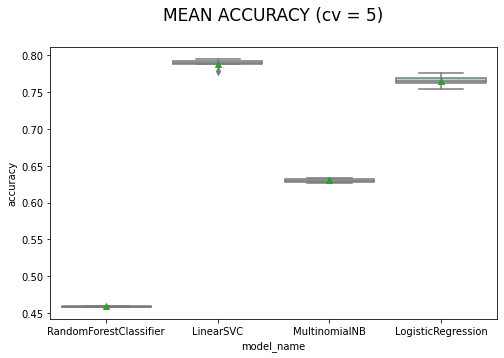

In [30]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=17);

In [31]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [34]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS



ValueError: Number of classes, 14, does not match size of target_names, 15. Try specifying the labels parameter

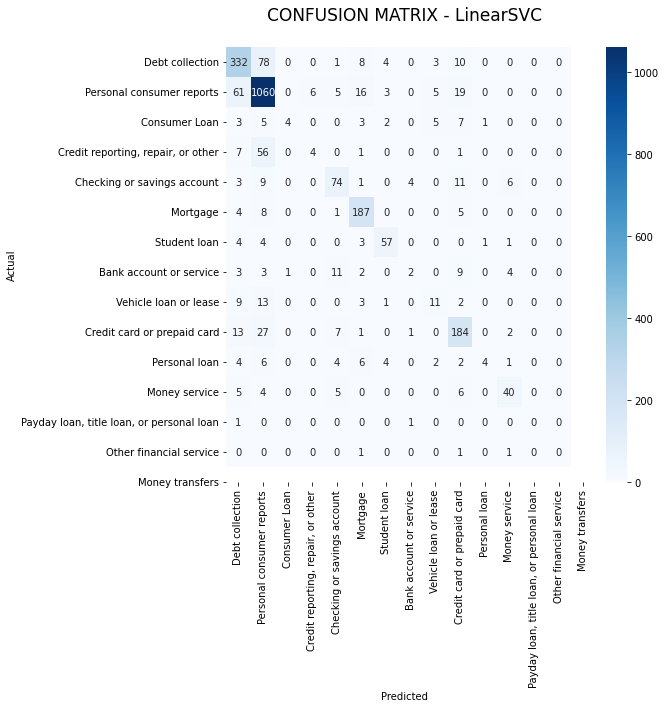

In [32]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=17);

In [33]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 
                                                                'Consumer_complaint']])
      print('')

'Personal consumer reports' predicted as 'Debt collection' : 61 examples.


,Product,Consumer_complaint
532920,Personal consumer reports,I have an account XXXX XXXX. I have challenged...
1539712,Personal consumer reports,I sent a second re investigation letter into E...
1514971,Personal consumer reports,XXXX XXXX # XXXX is reporting a collection to...
504607,Personal consumer reports,"XXXX XXXX XXXX XXXX XXXXXXXX XXXX XXXXXXXX, FL..."
1241227,Personal consumer reports,Navy Federal Credit Union at XXXX XXXX XXXX XX...
...,...,...
505279,Personal consumer reports,I went to the XXXX XXXX sometime in XXXX when ...
791353,Personal consumer reports,I AM XXXX XXXX AND IM SUBMITTING THIS COMPLAIN...
1808411,Personal consumer reports,Attached are 6 counterfeit note report for eac...
1182733,Personal consumer reports,portfolio recovery associates {$2600.00} i hav...


IndexError: index 14 is out of bounds for axis 0 with size 14

In [24]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



==> 'Bank account or service':
  * Top unigrams: bank, overdraft, 2015, points
  * Top bigrams: fargo bank, promotional code, xxxx 2015, 00 fees

==> 'Checking or savings account':
  * Top unigrams: bank, checking, chime, cd
  * Top bigrams: savings account, open new, funds available, make online

==> 'Consumer Loan':
  * Top unigrams: truck, toyota, financed, installment
  * Top bigrams: installment loan, paid company, loan sold, unable pay

==> 'Credit card or prepaid card':
  * Top unigrams: card, capital, synchrony, cards
  * Top bigrams: american express, pay balance, paypal credit, care credit

==> 'Credit reporting, repair, or other':
  * Top unigrams: equifax, reinserted, transunion, experian
  * Top bigrams: xxxx reported, xxxx bureaus, xxxx credit, victim inquiry

==> 'Debt collection':
  * Top unigrams: debt, collection, recovery, owe
  * Top bigrams: request validation, xxxx written, false info, pay xxxx

==> 'Money service':
  * Top unigrams: coinbase, zelle, app, paypal


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [43]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""

print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


In [44]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Personal consumer reports']


In [45]:
df2[df2['Consumer_complaint'] == new_complaint_2]

,Product,Consumer_complaint,category_id
